In [19]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm


###PSNR from folder results

In [7]:
import os

# Set the directory containing the images
image_folder = "/home/vittorio/Scrivania/ETH/Upsampling/Upsampling_CFD/results/test_DAT_x2_obstacles_final/visualization/test_set_physic"
# The suffix you want to remove
suffix_to_remove = "_suffix"

# Get all files in the directory
for filename in os.listdir(image_folder):
    # Check if it's a file (not a directory) and if it ends with the suffix you want to remove
    if os.path.isfile(os.path.join(image_folder, filename)):
        # Split the filename into name and extension
        file_name, file_ext = os.path.splitext(filename)
        
        # If the file ends with the suffix, rename it
        if file_name.endswith(suffix_to_remove):
            new_name = file_name[:-len(suffix_to_remove)] + file_ext
            # Rename the file
            os.rename(os.path.join(image_folder, filename), os.path.join(image_folder, new_name))
            print(f"Renamed: {filename} -> {new_name}")

Renamed: data_597_y_suffix.png -> data_597_y.png
Renamed: data_720_y_suffix.png -> data_720_y.png
Renamed: data_954_y_suffix.png -> data_954_y.png
Renamed: data_227_y_suffix.png -> data_227_y.png
Renamed: data_70_y_suffix.png -> data_70_y.png
Renamed: data_389_y_suffix.png -> data_389_y.png
Renamed: data_450_y_suffix.png -> data_450_y.png
Renamed: data_907_y_suffix.png -> data_907_y.png
Renamed: data_659_y_suffix.png -> data_659_y.png
Renamed: data_655_y_suffix.png -> data_655_y.png
Renamed: data_371_y_suffix.png -> data_371_y.png
Renamed: data_39_y_suffix.png -> data_39_y.png
Renamed: data_239_y_suffix.png -> data_239_y.png
Renamed: data_956_y_suffix.png -> data_956_y.png
Renamed: data_682_y_suffix.png -> data_682_y.png
Renamed: data_967_y_suffix.png -> data_967_y.png
Renamed: data_909_y_suffix.png -> data_909_y.png
Renamed: data_663_y_suffix.png -> data_663_y.png
Renamed: data_132_y_suffix.png -> data_132_y.png
Renamed: data_669_y_suffix.png -> data_669_y.png
Renamed: data_260_y_suff

In [3]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm



def psnr(pred, target, max_val=1):
    mse = F.mse_loss(pred, target)
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr

def calculate_psnr_from_folders(pred_folder, target_folder, upscale_factor=1, device='cpu', max_val=None):
    """
    Calculate the average PSNR between images in two folders.

    Args:
        pred_folder (str): Path to the folder containing predicted/downsampled images.
        target_folder (str): Path to the folder containing target high-resolution images.
        upscale_factor (int, optional): Factor by which to upscale the predicted images. Defaults to 1.
        device (torch.device, optional): Device to perform computations on. Defaults to 'cpu'.
        max_val (float, optional): Maximum possible pixel value. If None, it will be computed from target images.

    Returns:
        float: Average PSNR value in decibels.
    """


    total_psnr = 0.0
    total_images = 0

    # Get lists of image filenames
    pred_images = sorted([f for f in os.listdir(pred_folder) if os.path.isfile(os.path.join(pred_folder, f))])
    target_images = sorted([f for f in os.listdir(target_folder) if os.path.isfile(os.path.join(target_folder, f))])

    # Create a mapping from target image base names to their full paths
    target_mapping = {}
    for img_name in target_images:
        base_name, ext = os.path.splitext(img_name)
        target_mapping[base_name] = os.path.join(target_folder, img_name)

    for pred_img_name in tqdm(pred_images, desc="Calculating PSNR"):
        # Extract base name to match with target
        pred_base_name, pred_ext = os.path.splitext(pred_img_name)
        
        # Find corresponding target image
        target_img_path = target_mapping.get(pred_base_name)
        if target_img_path is None:
            print(f"Warning: No matching target image found for '{pred_img_name}'. Skipping.")
            continue  # Skip if no matching target image is found

        pred_path = os.path.join(pred_folder, pred_img_name)
        target_path = target_img_path

        try:
            # Open images and convert to RGB
            pred_img = Image.open(pred_path).convert('RGB')
            target_img = Image.open(target_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image pair ({pred_path}, {target_path}): {e}. Skipping.")
            continue  # Skip unreadable images

        # Convert images to tensors and normalize
        pred_tensor = torch.from_numpy(np.array(pred_img)).float() / 255.0  # Adjust normalization if needed
        target_tensor = torch.from_numpy(np.array(target_img)).float() / 255.0

        # Ensure the dimensions are [C, H, W]
        pred_tensor = pred_tensor.permute(2, 0, 1).to(device)  # Shape: [C, H, W]
        target_tensor = target_tensor.permute(2, 0, 1).to(device)  # Shape: [C, H, W]

        # Optionally plot the first two images for inspection
        if total_images < 2:
            # plot_two_images(pred_img_np, target_img_np)
            print(f"Processing image: {pred_img_name}")

        # Upscale the predicted image if upscale_factor > 1 using PyTorch's interpolate
        if upscale_factor > 1:
            pred_tensor = F.interpolate(pred_tensor.unsqueeze(0), scale_factor=upscale_factor, mode='bicubic', align_corners=False)
            # Ensure the upscaled image matches the target size
            target_height, target_width = target_tensor.shape[1], target_tensor.shape[2]
            pred_tensor = F.interpolate(pred_tensor, size=(target_height, target_width), mode='bicubic', align_corners=False)
            pred_tensor = pred_tensor.squeeze(0)

        # Add batch dimension for PSNR function: [1, C, H, W]
        pred_tensor = pred_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        # Compute PSNR
        with torch.no_grad():
            psnr_value = psnr(pred_tensor, target_tensor, max_val=1).item()
        total_psnr += psnr_value
        total_images += 1

    if total_images == 0:
        raise ValueError("No images were processed. Please check the folder paths and image names.")

    # Compute average PSNR
    avg_psnr = total_psnr / total_images
    return avg_psnr


# Define folder paths
pred_folder_resShift = "/home/vittorio/Documenti/Upsampling_CFD/results/test_DAT_x4_Scalar_Obstacles/visualization/no_physic_mass"
pred_folder_bicubic_downsampled = "/home/vittorio/Documenti/Upsampling_CFD/datasets/DatasetObstacles_4/test/low_res"
target_folder_resShift = "/home/vittorio/Documenti/Upsampling_CFD/datasets/DatasetObstacles_4/test/high_res"

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate PSNR for the model's output (ResShift)
avg_psnr_resShift = calculate_psnr_from_folders(
    pred_folder=pred_folder_resShift,
    target_folder=target_folder_resShift,
    upscale_factor=1,  # No upscaling needed for model outputs
    device=device
)



# Calculate PSNR for Bicubic upscaled images
avg_psnr_bicubic = calculate_psnr_from_folders(
    pred_folder=pred_folder_bicubic_downsampled,
    target_folder=target_folder_resShift,
    upscale_factor=2,  # Upscale by a factor of 2
    device=device
)


# Print the results
print(f"\nValidation PSNR - Model Output (ResShift): {avg_psnr_resShift:.2f} dB")
print(f"Validation PSNR - Bicubic Upscaling: {avg_psnr_bicubic:.2f} dB")

/home/vittorio/anaconda3/envs/Upsampling/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Calculating PSNR: 100%|██████████| 200/200 [00:02<00:00, 95.27it/s]


Processing image: data_0_y.png
Processing image: data_1000_y.png


Calculating PSNR: 100%|██████████| 200/200 [00:00<00:00, 2712.57it/s]

Processing image: data_0_y.jpg
Processing image: data_1000_y.jpg

Validation PSNR - Model Output (ResShift): 21.66 dB
Validation PSNR - Bicubic Upscaling: 24.57 dB


In [4]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm  # Import tqdm for progress bars

def ssim(pred, target, C1=0.01**2, C2=0.03**2):
    mu_x = F.conv2d(pred, weight=torch.ones([pred.shape[1], 1, 11, 11]).to(pred.device) / 121, padding=5, groups=pred.shape[1])
    mu_y = F.conv2d(target, weight=torch.ones([target.shape[1], 1, 11, 11]).to(target.device) / 121, padding=5, groups=target.shape[1])

    sigma_x = F.conv2d(pred * pred, weight=torch.ones([pred.shape[1], 1, 11, 11]).to(pred.device) / 121, padding=5, groups=pred.shape[1]) - mu_x ** 2
    sigma_y = F.conv2d(target * target, weight=torch.ones([target.shape[1], 1, 11, 11]).to(target.device) / 121, padding=5, groups=target.shape[1]) - mu_y ** 2
    sigma_xy = F.conv2d(pred * target, weight=torch.ones([pred.shape[1], 1, 11, 11]).to(pred.device) / 121, padding=5, groups=pred.shape[1]) - mu_x * mu_y

    ssim_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    ssim_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

    ssim = ssim_n / ssim_d
    return ssim.mean()

def calculate_ssim_from_folders(pred_folder, target_folder, upscale_factor=1, device='cpu'):
    """
    Calculate the average SSIM between images in two folders.

    Args:
        pred_folder (str): Path to the folder containing predicted/downsampled images.
        target_folder (str): Path to the folder containing target high-resolution images.
        upscale_factor (int, optional): Factor by which to upscale the predicted images.
                                        Defaults to 1 (no upscaling).
        device (torch.device, optional): Device to perform computations on. Defaults to 'cpu'.

    Returns:
        float: Average SSIM value.
    """
    total_ssim = 0.0
    total_images = 0

    # Get lists of image filenames
    pred_images = sorted(os.listdir(pred_folder))
    target_images = sorted(os.listdir(target_folder))

    # Create a mapping from target image base names to their full paths
    target_mapping = {}
    for img_name in target_images:
        base_name, ext = os.path.splitext(img_name)
        target_mapping[base_name] = os.path.join(target_folder, img_name)

    for pred_img_name in tqdm(pred_images, desc="Calculating SSIM"):
        # Extract base name to match with target
        pred_base_name, pred_ext = os.path.splitext(pred_img_name)
        
        # Find corresponding target image
        target_img_path = target_mapping.get(pred_base_name)
        if target_img_path is None:
            print(f"Warning: No matching target image found for '{pred_img_name}'. Skipping.")
            continue  # Skip if no matching target image is found

        pred_path = os.path.join(pred_folder, pred_img_name)
        target_path = target_img_path

        # Open images and convert to RGB
        pred_img = Image.open(pred_path).convert('RGB')
        target_img = Image.open(target_path).convert('RGB')

        # Convert images to tensors and normalize
        pred_tensor = torch.from_numpy(np.array(pred_img)).float() / 255.0
        target_tensor = torch.from_numpy(np.array(target_img)).float() / 255.0

        # Ensure the dimensions are [C, H, W]
        pred_tensor = pred_tensor.permute(2, 0, 1).to(device)  # Shape: [C, H, W]
        target_tensor = target_tensor.permute(2, 0, 1).to(device)  # Shape: [C, H, W]

        # Upscale the predicted image if upscale_factor > 1 using PyTorch's interpolate
        if upscale_factor > 1:
            # Add batch dimension: [1, C, H, W]
            pred_tensor = pred_tensor.unsqueeze(0)

            # Calculate new spatial dimensions based on upscale_factor
            # Alternatively, you can use scale_factor=upscale_factor in interpolate
            # but here we ensure it matches the target dimensions
            target_height, target_width = target_tensor.shape[1], target_tensor.shape[2]
            pred_tensor = F.interpolate(pred_tensor, size=(target_height, target_width), mode='bicubic', align_corners=False)

            # Remove batch dimension: [C, H, W]
            pred_tensor = pred_tensor.squeeze(0)

        # Add batch dimension for SSIM function: [1, C, H, W]
        pred_tensor = pred_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        # Compute SSIM
        with torch.no_grad():
            ssim_value = ssim(pred_tensor, target_tensor).item()
        total_ssim += ssim_value
        total_images += 1

    if total_images == 0:
        raise ValueError("No images were processed. Please check the folder paths and image names.")

    # Compute average SSIM
    avg_ssim = total_ssim / total_images
    print(total_images)
    return avg_ssim

# Define folder paths
# Define folder paths
# Define folder paths
# Define folder paths
# Define folder paths
# Define folder paths
# Define folder paths
pred_folder_resShift = "/home/vittorio/Documenti/Upsampling_CFD/results/test_DAT_x4_Scalar_Obstacles/visualization/no_physic_mass"
pred_folder_bicubic_downsampled = "/home/vittorio/Documenti/Upsampling_CFD/datasets/DatasetObstacles_4/test/low_res"
target_folder_resShift = "/home/vittorio/Documenti/Upsampling_CFD/datasets/DatasetObstacles_4/test/high_res"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate SSIM for the model's output (ResShift)
avg_ssim_resShift = calculate_ssim_from_folders(
    pred_folder=pred_folder_resShift,
    target_folder=target_folder_resShift,
    upscale_factor=1,  # No upscaling needed for model outputs
    device=device
)


# Calculate SSIM for Bicubic upscaled images
avg_ssim_bicubic = calculate_ssim_from_folders(
    pred_folder=pred_folder_bicubic_downsampled,
    target_folder=target_folder_resShift,
    upscale_factor=4,  # Upscale by a factor of 2
    device=device
)

# Print the results
print(f"\nValidation SSIM - Model Output (ResShift): {avg_ssim_resShift:.4f}")
print(f"Validation SSIM - Bicubic Upscaling: {avg_ssim_bicubic:.4f}")


Calculating SSIM: 100%|██████████| 200/200 [00:00<00:00, 598.66it/s]


200


Calculating SSIM: 100%|██████████| 200/200 [00:00<00:00, 1727.98it/s]

200

Validation SSIM - Model Output (ResShift): 0.7356
Validation SSIM - Bicubic Upscaling: 0.7180


In [10]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm  # Import tqdm for progress bars

def rmse(pred, target, epsilon=1e-16):
    """
    Compute the Root Mean Squared Error (RMSE) between two images.

    Args:
        pred (torch.Tensor): Predicted image tensor of shape [N, C, H, W].
        target (torch.Tensor): Target image tensor of shape [N, C, H, W].
        epsilon (float, optional): Small value to avoid numerical issues. Defaults to 1e-16.

    Returns:
        float: RMSE value over the batch.
    """
    mse = F.mse_loss(pred, target, reduction='mean')
    rmse_value = torch.sqrt(mse + epsilon)  # Added epsilon for numerical stability
    return rmse_value.item()

def calculate_rmse_from_folders(pred_folder, target_folder, upscale_factor=1, device='cpu'):
    """
    Calculate the average RMSE between images in two folders.

    Args:
        pred_folder (str): Path to the folder containing predicted/downsampled images.
        target_folder (str): Path to the folder containing target high-resolution images.
        upscale_factor (int, optional): Factor by which to upscale the predicted images.
                                        Defaults to 1 (no upscaling).
        device (str or torch.device, optional): Device to perform computations on. Defaults to 'cpu'.

    Returns:
        float: Average RMSE value.
    """
    total_rmse = 0.0
    total_images = 0

    # Get lists of image filenames
    pred_images = sorted(os.listdir(pred_folder))
    target_images = sorted(os.listdir(target_folder))

    # Create a mapping from target image base names to their full paths
    target_mapping = {}
    for img_name in target_images:
        base_name, ext = os.path.splitext(img_name)
        target_mapping[base_name] = os.path.join(target_folder, img_name)

    for pred_img_name in tqdm(pred_images, desc="Calculating RMSE"):
        # Extract base name to match with target
        pred_base_name, pred_ext = os.path.splitext(pred_img_name)
        
        # Find corresponding target image
        target_img_path = target_mapping.get(pred_base_name)
        if target_img_path is None:
            print(f"Warning: No matching target image found for '{pred_img_name}'. Skipping.")
            continue  # Skip if no matching target image is found

        pred_path = os.path.join(pred_folder, pred_img_name)
        target_path = target_img_path

        # Open images and convert to RGB
        try:
            pred_img = Image.open(pred_path).convert('RGB')
            target_img = Image.open(target_path).convert('RGB')
        except Exception as e:
            print(f"Error opening images '{pred_img_name}' and/or '{os.path.basename(target_path)}': {e}. Skipping.")
            continue  # Skip if there's an error opening images

        # Convert images to tensors and normalize to [0, 1]
        pred_tensor = torch.from_numpy(np.array(pred_img)).float() / 255.0
        target_tensor = torch.from_numpy(np.array(target_img)).float() / 255.0

        # Rearrange dimensions to [C, H, W] and move to the specified device
        pred_tensor = pred_tensor.permute(2, 0, 1).to(device)  # Shape: [C, H, W]
        target_tensor = target_tensor.permute(2, 0, 1).to(device)  # Shape: [C, H, W]

        # Upscale the predicted image if upscale_factor > 1 using PyTorch's interpolate
        if upscale_factor > 1:
            # Add batch dimension: [1, C, H, W]
            pred_tensor = pred_tensor.unsqueeze(0)

            # Calculate new spatial dimensions based on upscale_factor
            # Alternatively, you can use scale_factor=upscale_factor in interpolate
            # but here we ensure it matches the target dimensions
            target_height, target_width = target_tensor.shape[1], target_tensor.shape[2]
            pred_tensor = F.interpolate(pred_tensor, size=(target_height, target_width), mode='bicubic', align_corners=False)

            # Remove batch dimension: [C, H, W]
            pred_tensor = pred_tensor.squeeze(0)

        # Add batch dimension for RMSE function: [1, C, H, W]
        pred_tensor = pred_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        # Compute RMSE
        with torch.no_grad():
            rmse_value = rmse(pred_tensor, target_tensor)
        total_rmse += rmse_value
        total_images += 1

    if total_images == 0:
        raise ValueError("No images were processed. Please check the folder paths and image names.")

    # Compute average RMSE
    avg_rmse = total_rmse / total_images
    print(f"Total Images Processed: {total_images}")
    return avg_rmse

# Example Usage:
if __name__ == "__main__":
    # Define folder paths
    pred_folder_resShift = "/home/vittorio/Scrivania/ETH/Upsampling/Upsampling_CFD/results/test_DAT_x2_obstacles_final/visualization/test_set_physic"
    pred_folder_bicubic_downsampled = "/home/vittorio/Scrivania/ETH/Upsampling/Upsampling_CFD/datasets/dataset_csv_geometry_Y/test/LW"
    target_folder_resShift = "/home/vittorio/Scrivania/ETH/Upsampling/Upsampling_CFD/datasets/dataset_csv_geometry_Y/test/HR"

    # Define device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Calculate RMSE for the model's output (ResShift)
    avg_rmse_resShift = calculate_rmse_from_folders(
        pred_folder=pred_folder_resShift,
        target_folder=target_folder_resShift,
        upscale_factor=4,  # No upscaling needed for model outputs
        device=device
    )



    # Print the results
    print(f"\nValidation RMSE - Model Output (ResShift): {avg_rmse_resShift:.4f}")
    #print(f"Validation RMSE - Bicubic Upscaling: {avg_rmse_bicubic:.4f}")


Calculating RMSE: 100%|██████████| 847/847 [00:00<00:00, 35798.18it/s]

ValueError: No images were processed. Please check the folder paths and image names.

In [27]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm  # Import tqdm for progress bars

def rmse(pred, target, epsilon=1e-16):
    """
    Compute the Root Mean Squared Error (RMSE) between two images.

    Args:
        pred (torch.Tensor): Predicted image tensor of shape [N, C, H, W].
        target (torch.Tensor): Target image tensor of shape [N, C, H, W].
        epsilon (float, optional): Small value to avoid numerical issues. Defaults to 1e-16.

    Returns:
        float: RMSE value over the batch.
    """
    mse = F.mse_loss(pred, target, reduction='mean')
    rmse_value = torch.sqrt(mse + epsilon)  # Added epsilon for numerical stability
    return rmse_value.item()

def calculate_rmse_from_folders(pred_folder, target_folder, upscale_factor=1, device='cpu'):
    """
    Calculate the average RMSE between images in two folders.

    Args:
        pred_folder (str): Path to the folder containing predicted/downsampled images.
        target_folder (str): Path to the folder containing target high-resolution images.
        upscale_factor (int, optional): Factor by which to upscale the predicted images.
                                        Defaults to 1 (no upscaling).
        device (str or torch.device, optional): Device to perform computations on. Defaults to 'cpu'.

    Returns:
        float: Average RMSE value.
    """
    total_rmse = 0.0
    total_images = 0

    # Get lists of image filenames
    pred_images = sorted(os.listdir(pred_folder))
    target_images = sorted(os.listdir(target_folder))

    # Create a mapping from target image base names to their full paths
    target_mapping = {}
    for img_name in target_images:
        base_name, ext = os.path.splitext(img_name)
        target_mapping[base_name] = os.path.join(target_folder, img_name)

    for pred_img_name in tqdm(pred_images, desc="Calculating RMSE"):
        # Extract base name to match with target
        pred_base_name, pred_ext = os.path.splitext(pred_img_name)
        
        # Find corresponding target image
        target_img_path = target_mapping.get(pred_base_name)
        if target_img_path is None:
            print(f"Warning: No matching target image found for '{pred_img_name}'. Skipping.")
            continue  # Skip if no matching target image is found

        pred_path = os.path.join(pred_folder, pred_img_name)
        target_path = target_img_path

        # Open images and convert to RGB
        try:
            pred_img = Image.open(pred_path).convert('RGB')
            target_img = Image.open(target_path).convert('RGB')
        except Exception as e:
            print(f"Error opening images '{pred_img_name}' and/or '{os.path.basename(target_path)}': {e}. Skipping.")
            continue  # Skip if there's an error opening images

        # Convert images to tensors and normalize to [0, 1]
        pred_tensor = torch.from_numpy(np.array(pred_img)).float() / 255.0
        target_tensor = torch.from_numpy(np.array(target_img)).float() / 255.0

        # Rearrange dimensions to [C, H, W] and move to the specified device
        pred_tensor = pred_tensor.permute(2, 0, 1).to(device)  # Shape: [C, H, W]
        target_tensor = target_tensor.permute(2, 0, 1).to(device)  # Shape: [C, H, W]

        # Upscale the predicted image if upscale_factor > 1 using PyTorch's interpolate
        if upscale_factor > 1:
            # Add batch dimension: [1, C, H, W]
            pred_tensor = pred_tensor.unsqueeze(0)

            # Calculate new spatial dimensions based on upscale_factor
            # Alternatively, you can use scale_factor=upscale_factor in interpolate
            # but here we ensure it matches the target dimensions
            target_height, target_width = target_tensor.shape[1], target_tensor.shape[2]
            pred_tensor = F.interpolate(pred_tensor, size=(target_height, target_width), mode='bicubic', align_corners=False)

            # Remove batch dimension: [C, H, W]
            pred_tensor = pred_tensor.squeeze(0)

        # Add batch dimension for RMSE function: [1, C, H, W]
        pred_tensor = pred_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        # Compute RMSE
        with torch.no_grad():
            rmse_value = rmse(pred_tensor, target_tensor)
        total_rmse += rmse_value
        total_images += 1

    if total_images == 0:
        raise ValueError("No images were processed. Please check the folder paths and image names.")

    # Compute average RMSE
    avg_rmse = total_rmse / total_images
    print(f"Total Images Processed: {total_images}")
    return avg_rmse

# Example Usage:
if __name__ == "__main__":
    # Define folder paths

    # Define folder paths
    pred_folder_resShift = "/home/vittorio/Documenti/Upsampling_CFD/results/test_DAT_x2_Outdoor_Scalar/visualization/test_set_physic"
    pred_folder_bicubic_downsampled = '/home/vittorio/Documenti/Upsampling_CFD/datasets/SplitDatasetOutdoorFlow_4/test/low_res'
    target_folder_resShift = '/home/vittorio/Documenti/Upsampling_CFD/datasets/SplitDatasetOutdoorFlow_4/test/high_res'
    # Define device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Calculate RMSE for the model's output (ResShift)
    avg_rmse_resShift = calculate_rmse_from_folders(
        pred_folder=pred_folder_bicubic_downsampled,
        target_folder=target_folder_resShift,
        upscale_factor=2,  # No upscaling needed for model outputs
        device=device
    )

    # Print the results
    print(f"\nValidation RMSE - Model Output (ResShift): {avg_rmse_resShift:.4f}")


Calculating RMSE: 100%|██████████| 193/193 [00:00<00:00, 231.94it/s]

Total Images Processed: 193

Validation RMSE - Model Output (ResShift): 0.1139


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def extract_centerline(image_path):
    """
    Extract the centerline data from a 2D velocity field image.
    Assumes the velocity field image is grayscale.

    Args:
        image_path (str): Path to the velocity field image.

    Returns:
        y (numpy array): Vertical positions (pixel indices).
        centerline (numpy array): Velocity values along the centerline.
    """
    # Load the image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    velocity_field = np.array(img)  # Convert to numpy array

    # Extract the centerline (middle column)
    center_column = velocity_field.shape[1] // 2
    centerline = velocity_field[:, center_column]  # Get the middle column

    # Vertical positions
    y = np.arange(velocity_field.shape[0])

    return y, centerline

# Paths to the predicted and ground truth images
predicted_image_path = "/home/vittorio/Scrivania/ETH/Upsampling/Upsampling_CFD/results/results_OLD_DAT/no_physics/test_DAT_x2_no_physics_Vector_Sigmoid_50k_Final/visualization/decoded/XZ_80_38.png"# Replace with your image path
ground_truth_image_path = "/home/vittorio/Scrivania/ETH/Upsampling/ResShift_4_scale/data/Scalar_Images/XZ_80_38.png" # Replace with your image path


# Extract centerline profiles
y, predicted_centerline = extract_centerline(predicted_image_path)
_, ground_truth_centerline = extract_centerline(ground_truth_image_path)

# Normalize the centerline values (optional, based on your data)
predicted_centerline = predicted_centerline / 255.0  # Scale to 0-1
ground_truth_centerline = ground_truth_centerline / 255.0  # Scale to 0-1

# Plot the centerline profiles
plt.figure(figsize=(8, 6))
plt.plot(predicted_centerline, y, label="Predicted", color="red")
plt.plot(ground_truth_centerline, y, label="Ground Truth", color="blue", linestyle="--")
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinate system
plt.xlabel("m/s")
plt.legend()
plt.grid()
plt.show()

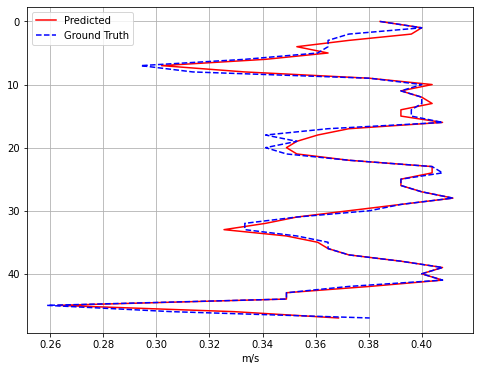

: 

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def extract_centerline(image_path):
    """
    Extract the centerline data from a 2D velocity field image.
    Assumes the velocity field image is grayscale.

    Args:
        image_path (str): Path to the velocity field image.

    Returns:
        y (numpy array): Vertical positions (pixel indices).
        centerline (numpy array): Velocity values along the centerline.
    """
    # Load the image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    velocity_field = np.array(img)  # Convert to numpy array

    # Extract the centerline (middle column)
    center_column = velocity_field.shape[1] // 2
    centerline = velocity_field[:, center_column]  # Get the middle column

    # Vertical positions
    y = np.arange(velocity_field.shape[0])

    return y, centerline

# Paths to the predicted and ground truth images
predicted_image_path = "/home/vittorio/Scrivania/ETH/Upsampling/Upsampling_CFD/results/results_OLD_DAT/no_physics/test_DAT_x2_no_physics_Vector_Sigmoid_50k_Final/visualization/decoded/XZ_80_38.png"# Replace with your image path
ground_truth_image_path = "/home/vittorio/Scrivania/ETH/Upsampling/ResShift_4_scale/data/Scalar_Images/XZ_80_38.png" # Replace with your image path


# Extract centerline profiles
y, predicted_centerline = extract_centerline(predicted_image_path)
_, ground_truth_centerline = extract_centerline(ground_truth_image_path)

# Normalize the centerline values (optional, based on your data)
predicted_centerline = predicted_centerline / 255.0  # Scale to 0-1
ground_truth_centerline = ground_truth_centerline / 255.0  # Scale to 0-1

# Plot the centerline profiles
plt.figure(figsize=(8, 6))
plt.plot(predicted_centerline, y, label="Predicted", color="red")
plt.plot(ground_truth_centerline, y, label="Ground Truth", color="blue", linestyle="--")
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinate system
plt.xlabel("m/s")
plt.legend()
plt.grid()
plt.show()

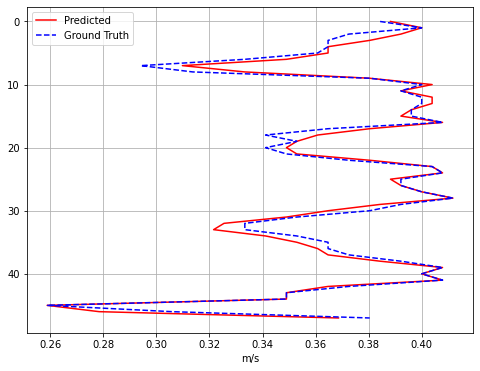

In [18]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def extract_centerline(image_path):
    """
    Extract the centerline data from a 2D velocity field image.
    Assumes the velocity field image is grayscale.

    Args:
        image_path (str): Path to the velocity field image.

    Returns:
        y (numpy array): Vertical positions (pixel indices).
        centerline (numpy array): Velocity values along the centerline.
    """
    # Load the image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    velocity_field = np.array(img)  # Convert to numpy array

    # Extract the centerline (middle column)
    center_column = velocity_field.shape[1] // 2
    centerline = velocity_field[:, center_column]  # Get the middle column

    # Vertical positions
    y = np.arange(velocity_field.shape[0])

    return y, centerline

# Paths to the predicted and ground truth images
predicted_image_path = "/home/vittorio/Documenti/Upsampling_CFD/results/test_DAT_x2_Indoor_umass_0.35_Vector/visualization/decoded/XZ_80_38.png" # Replace with your image path
ground_truth_image_path = "/home/vittorio/Scrivania/ETH/Upsampling/ResShift_4_scale/data/Scalar_Images/XZ_80_38.png" # Replace with your image path


# Extract centerline profiles
y, predicted_centerline = extract_centerline(predicted_image_path)
_, ground_truth_centerline = extract_centerline(ground_truth_image_path)

# Normalize the centerline values (optional, based on your data)
predicted_centerline = predicted_centerline / 255.0  # Scale to 0-1
ground_truth_centerline = ground_truth_centerline / 255.0  # Scale to 0-1

# Plot the centerline profiles
plt.figure(figsize=(8, 6))
plt.plot(predicted_centerline, y, label="Predicted", color="red")
plt.plot(ground_truth_centerline, y, label="Ground Truth", color="blue", linestyle="--")
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinate system
plt.xlabel("m/s")
plt.legend()
plt.grid()
plt.show()